# Ultrasound speckle tracking

This notebook demonstrates ultrasound speckle tracking using both optical flow method with the Lucas-Kanade algorithm as well as a segmentation-based approach on cardiac ultrasound data from the CAMUS dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/speckle_tracking_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/speckle_tracking_example.ipynb)

‼️ **Important:** This notebook is optimized for **GPU/TPU**. Code execution on a **CPU** may be very slow.

If you are running in Colab, please enable a hardware accelerator via:

**Runtime → Change runtime type → Hardware accelerator → GPU/TPU** 🚀. 

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras import ops

import zea
from zea.models.lv_segmentation import AugmentedCamusSeg, INFERENCE_SIZE
from zea.tracking import LucasKanadeTracker, SegmentationTracker
from zea.visualize import set_mpl_style
from zea.io_lib import matplotlib_figure_to_numpy, save_to_gif
from zea.func import find_contour

zea.init_device(verbose=False)
set_mpl_style()

zea: Using backend 'jax'


In [4]:
n_frames = 13
n_points = 20
max_iterations = 30

## Load ultrasound dataset

Load a cardiac ultrasound sequence:

In [5]:
us_path = "hf://zeahub/camus-sample/test/patient0451/patient0451_2CH_half_sequence.hdf5"

with zea.File(us_path) as file:
    frames = file.load_data("image_sc")

frames = frames[:n_frames]

print(f"Loaded {n_frames} frames of shape {frames[0].shape}")

Loaded 13 frames of shape (519, 630)


## Extract initial points

Use a segmentation model to find the myocardium contour and sample points. For more details see the [segmentation example notebook](../models/left_ventricle_segmentation_example.ipynb).

In [6]:
# Load segmentation model
seg_model = AugmentedCamusSeg.from_preset("augmented_camus_seg")
size = (INFERENCE_SIZE, INFERENCE_SIZE)
original_size = frames[0].shape


def segmentation_preprocess_fn(frame, size=size):
    frame_input = frame[None, :, :, None]
    frame_input = ops.image.resize(frame_input, size)
    frame_input = np.transpose(frame_input, (0, 3, 1, 2))
    return frame_input


def segmentation_postprocess_fn(frame, original_size=original_size, label=2):
    output = ops.squeeze(frame, axis=0)
    mask = output[label]
    mask = ops.image.resize(mask[None, ..., None], (original_size[0], original_size[1]))
    mask = ops.squeeze(mask, axis=(0, 3))
    mask = ops.where(mask >= 0.5, 1, 0).astype(np.uint8)
    return mask


# Segment first frame
frame_input = segmentation_preprocess_fn(frames[0], size=size)

outputs = seg_model.call(frame_input)

mask = segmentation_postprocess_fn(outputs, frames[0].shape, label=2)

contour = find_contour(mask)

# Sample 20 points
indices = np.linspace(0, len(contour) - 1, n_points, dtype=int)
initial_points = contour[indices].astype(np.float32)

config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/134M [00:00<?, ?B/s]

Visualize the initial points 

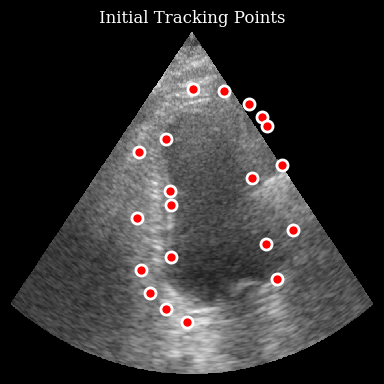

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(frames[0], cmap="gray", aspect="auto")
ax.plot(
    initial_points[:, 1],
    initial_points[:, 0],
    "ro",
    markersize=8,
    markeredgecolor="white",
    markeredgewidth=2,
)
ax.set_title("Initial Tracking Points")
ax.axis("off")
plt.tight_layout()
plt.show()

## Track points

Initialize the tracker and track through the sequence:

In [8]:
tracker = LucasKanadeTracker(win_size=(32, 32), max_level=3, max_iterations=max_iterations)

trajectories = tracker.track_sequence(frames, initial_points)

Now we can visualize the trajectories of the tracked points:

In [9]:
viz_frames = []

for t in range(n_frames):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(frames[t], cmap="gray", aspect="auto")

    for i in range(n_points):
        traj = np.array(trajectories[i][: t + 1])

        if len(traj) > 1:
            ax.plot(traj[:, 1], traj[:, 0], "r-", alpha=0.4, linewidth=2)

        ax.plot(
            traj[-1, 1],
            traj[-1, 0],
            "o",
            color="red",
            markersize=8,
            markeredgecolor="white",
            markeredgewidth=2,
        )

    ax.set_title(f"Frame {t}/{n_frames - 1}")
    ax.axis("off")
    fig.tight_layout()

    viz_frames.append(matplotlib_figure_to_numpy(fig))
    plt.close(fig)

save_to_gif(viz_frames, "tracking_result.gif", fps=10)

zea: Successfully saved GIF to -> tracking_result.gif


![Tracking Result](tracking_result.gif)

## Comparison with segmentation-based tracking

In the following we will compare optical flow tracking with a segmentation-based approach.

- **Left (Red)**: Lucas-Kanade optical flow tracking - tracks points smoothly between frames
- **Right (Green)**: Segmentation-based tracking - finds closest contour points in each segmented frame

In [10]:
seg_tracker = SegmentationTracker(
    model=seg_model,
    preprocess_fn=segmentation_preprocess_fn,
    postprocess_fn=segmentation_postprocess_fn,
)

seg_trajectories = seg_tracker.track_sequence(frames, initial_points)

In [11]:
comparison_frames = []

methods = [
    {"trajectories": trajectories, "color": "red", "title": "Lucas-Kanade"},
    {"trajectories": seg_trajectories, "color": "green", "title": "Segmentation-based"},
]

for t in range(n_frames):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for ax, method in zip(axes, methods):
        ax.imshow(frames[t], cmap="gray", aspect="auto")

        for i in range(n_points):
            traj = np.array(method["trajectories"][i][: t + 1])

            if len(traj) > 1:
                ax.plot(traj[:, 1], traj[:, 0], method["color"], alpha=0.4, linewidth=2)

            ax.plot(
                traj[-1, 1],
                traj[-1, 0],
                "o",
                color=method["color"],
                markersize=8,
                markeredgecolor="white",
                markeredgewidth=2,
            )

        ax.set_title(method["title"])
        ax.axis("off")

    fig.suptitle(f"Frame {t}/{n_frames - 1}", y=0.95)

    comparison_frames.append(matplotlib_figure_to_numpy(fig))
    plt.close(fig)

save_to_gif(comparison_frames, "tracking_comparison.gif", fps=10)

zea: Successfully saved GIF to -> tracking_comparison.gif


![Tracking Comparison](./tracking_comparison.gif)